## Importing the required libraries

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from clusteval import clusteval
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from datetime import date
import warnings
warnings.filterwarnings('ignore')

### <span style="color: orange;">Customization:</span>

In [14]:
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option('display.float_format',lambda x: '%.2f' % x)

## <span style="color: orange;">Loading the dataset:</span>

In [15]:
df = pd.read_csv('Transactions.csv')
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.00
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.00
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.00
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.00
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.50


In [16]:
df.shape

(1048567, 9)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   TransactionID            1048567 non-null  object 
 1   CustomerID               1048567 non-null  object 
 2   CustomerDOB              1045170 non-null  object 
 3   CustGender               1047467 non-null  object 
 4   CustLocation             1048416 non-null  object 
 5   CustAccountBalance       1046198 non-null  float64
 6   TransactionDate          1048567 non-null  object 
 7   TransactionTime          1048567 non-null  int64  
 8   TransactionAmount (INR)  1048567 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 72.0+ MB


In [18]:
df.describe()

,CustAccountBalance,TransactionTime,TransactionAmount (INR)
count,1046198.00,1048567.00,1048567.00
mean,115403.54,157087.53,1574.34
std,846485.38,51261.85,6574.74
min,0.00,0.00,0.00
25%,4721.76,124030.00,161.00
50%,16792.18,164226.00,459.03
75%,57657.36,200010.00,1200.00
max,115035495.10,235959.00,1560034.99


In [19]:
df.isnull().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

## <span style="color: orange;">Feature Engineering:</span>

In [20]:
df.drop(['TransactionID','CustomerID'],axis=1,inplace=True)
# These columns hold no valuable info for us.

In [21]:
df['CustGender'].value_counts()

CustGender
M    765530
F    281936
T         1
Name: count, dtype: int64

In [22]:
df.drop(df[df['CustGender'].isin(['T'])].index,axis=0,inplace=True)
# We drop this row because it has only one customer.

In [23]:
df['CustGender'].unique()

array(['F', 'M', nan], dtype=object)

#### <span style="color: orange;">Creating new column (Age):</span>

In [24]:
df = df[~df['CustomerDOB'].isna()]
df.CustomerDOB = pd.to_datetime(df.CustomerDOB,errors='coerce')

In [25]:
def age(birthdate):
    today = date.today()
    age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
    return age

In [26]:
df['Age'] = df.CustomerDOB.apply(age)

In [27]:
df = df[df['Age']>0]
df.drop('CustomerDOB',axis=1,inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 950937 entries, 0 to 1048566
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CustGender               950051 non-null  object 
 1   CustLocation             950826 non-null  object 
 2   CustAccountBalance       948769 non-null  float64
 3   TransactionDate          950937 non-null  object 
 4   TransactionTime          950937 non-null  int64  
 5   TransactionAmount (INR)  950937 non-null  float64
 6   Age                      950937 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 58.0+ MB


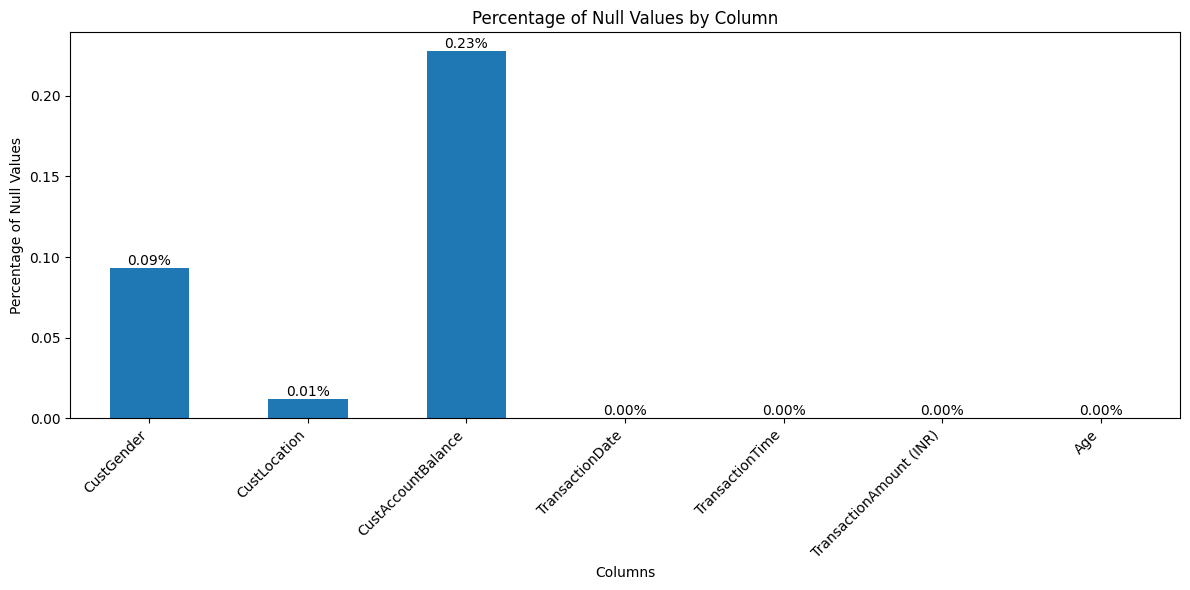

In [29]:
null_percentages = df.isnull().sum() / len(df) * 100
plt.figure(figsize=(12, 6))
null_percentages.plot(kind='bar')
plt.title('Percentage of Null Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Null Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
for i, v in enumerate(null_percentages):
    plt.text(i, v, f'{v:.2f}%', ha='center', va='bottom')
plt.show()

#### <span style="color: orange;">We drop these rows because their percentage is below 1 percent:</span>

In [30]:
df = df[~df['CustGender'].isna()]

In [31]:
df = df[~df['CustLocation'].isna()]

In [32]:
df.CustAccountBalance = df.CustAccountBalance.fillna(df.groupby('CustLocation')['CustAccountBalance'].transform('mean'))

In [33]:
df = df[~df.CustAccountBalance.isna()]

In [34]:
df.isna().sum()

CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
Age                        0
dtype: int64

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 949780 entries, 0 to 1048566
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CustGender               949780 non-null  object 
 1   CustLocation             949780 non-null  object 
 2   CustAccountBalance       949780 non-null  float64
 3   TransactionDate          949780 non-null  object 
 4   TransactionTime          949780 non-null  int64  
 5   TransactionAmount (INR)  949780 non-null  float64
 6   Age                      949780 non-null  int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 58.0+ MB


In [36]:
df.TransactionDate = pd.to_datetime(df.TransactionDate,errors='coerce')

In [37]:
df['TransactionMonth'] = df.TransactionDate.dt.month
df['TransactionMonthName'] = df.TransactionDate.dt.month_name()
df['TransactionDay'] = df.TransactionDate.dt.day
df['TransactionDayName'] = df.TransactionDate.dt.day_name()

In [38]:
df.drop('TransactionDate',axis=1,inplace=True)

## <span style="color: orange;">Exploratory Data Analysis (EDA):</span>

([<matplotlib.patches.Wedge at 0x1c0eb3b86e0>,
 [Text(-0.7966914537843421, 0.897375466272057, 'M'),
  Text(0.7303004222854848, -0.8225942457917165, 'F')],
 [Text(-0.46473668137419955, 0.5234690219920332, '73.11%'),
  Text(0.39834568488299166, -0.4486877704318453, '26.89%')])

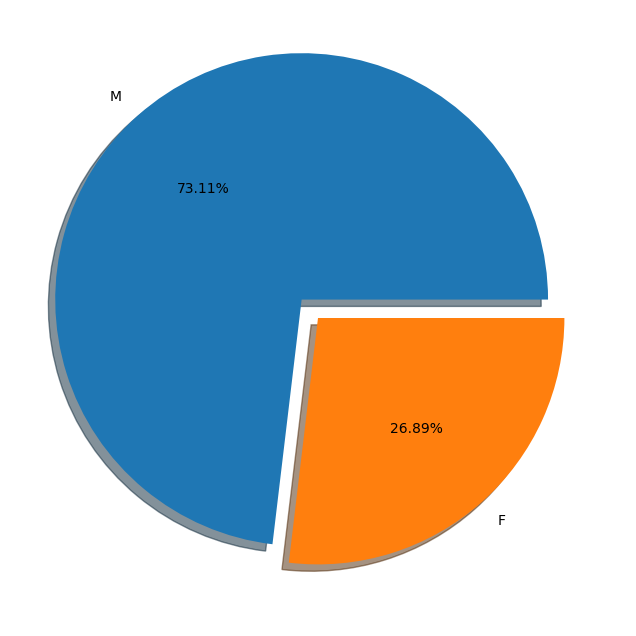

In [39]:
labels = df.CustGender.value_counts().keys()
values = df.CustGender.value_counts().values
explode = (0.1,0)
plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.2f%%')

<span style="color: pink;">A significant proportion of bank customers are males accounting for about 73% of the total share.</span>

Text(0, 0.5, 'Transaction Amount (INR)')

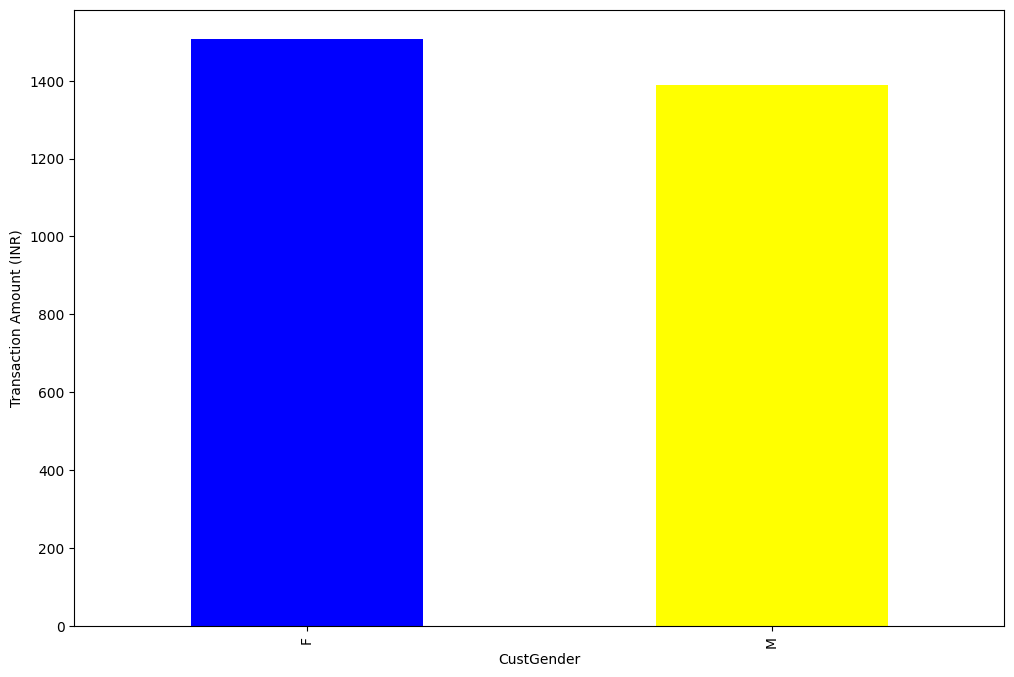

In [40]:
ax = df.groupby('CustGender')['TransactionAmount (INR)'].mean().plot(kind='bar',color=['blue','yellow'])
plt.ylabel('Transaction Amount (INR)')

<span style="color: pink;">At an average, females make slightly higher transactions than males.</span>

Text(0, 0.5, 'Customer Account Balance')

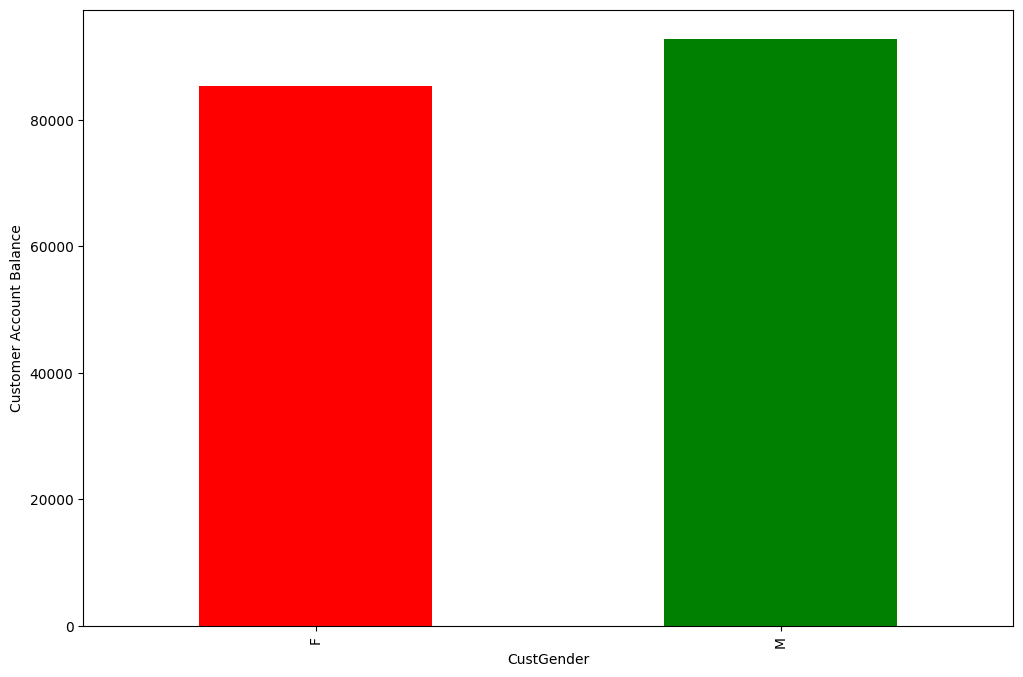

In [41]:
ax = df.groupby('CustGender')['CustAccountBalance'].mean().plot(kind='bar',color=['red','green'])
plt.ylabel('Customer Account Balance')

<span style="color: pink;">At an average, male customers have marginally higher account balances in comparison to their female counterparts.</span>

Text(0.5, 1.0, 'Monthly Comparison of Spending Habits of Male & Female Customers')

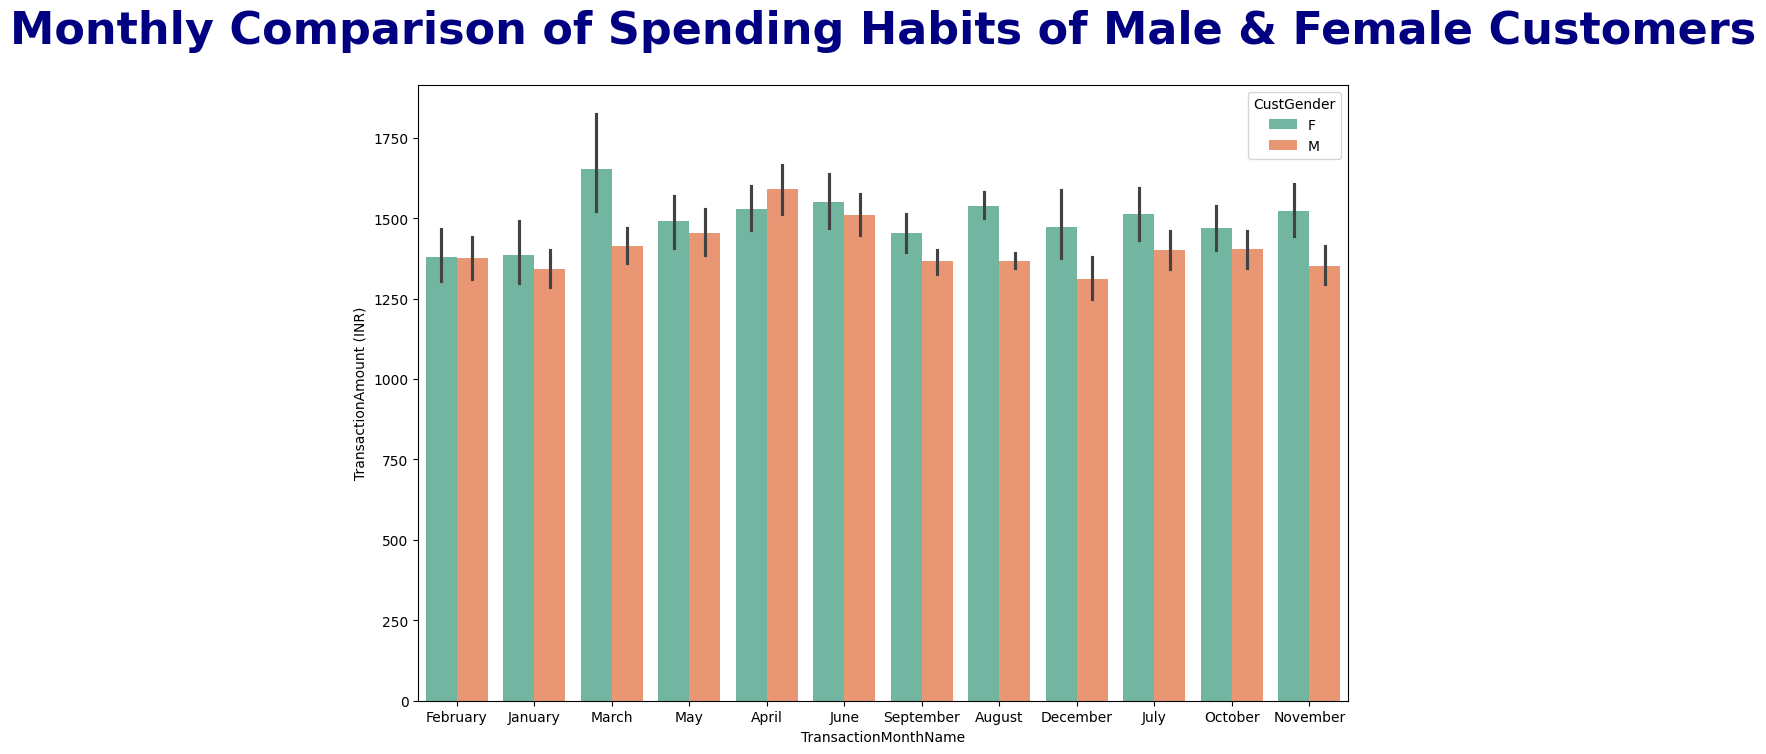

In [42]:
sns.barplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',palette='Set2',hue='CustGender')
plt.title('Monthly Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30)

<span style="color: pink;">Male customers make higher transactions than their female counterparts only during the months of February and April. In all the remaining months, female customers perform greater transactions. Therefore, the bank must provide more special offers and incentives to female customers as they are likely to be substantially active in making larger transactions almost throughout the entire year.</span>

<span style="color: pink;">Higher value transactions are mostly done during the months of March, April and June.</span>

Text(0.5, 1.0, 'Weekday-Wise Comparison of Spending Habits of Male & Female Customers')

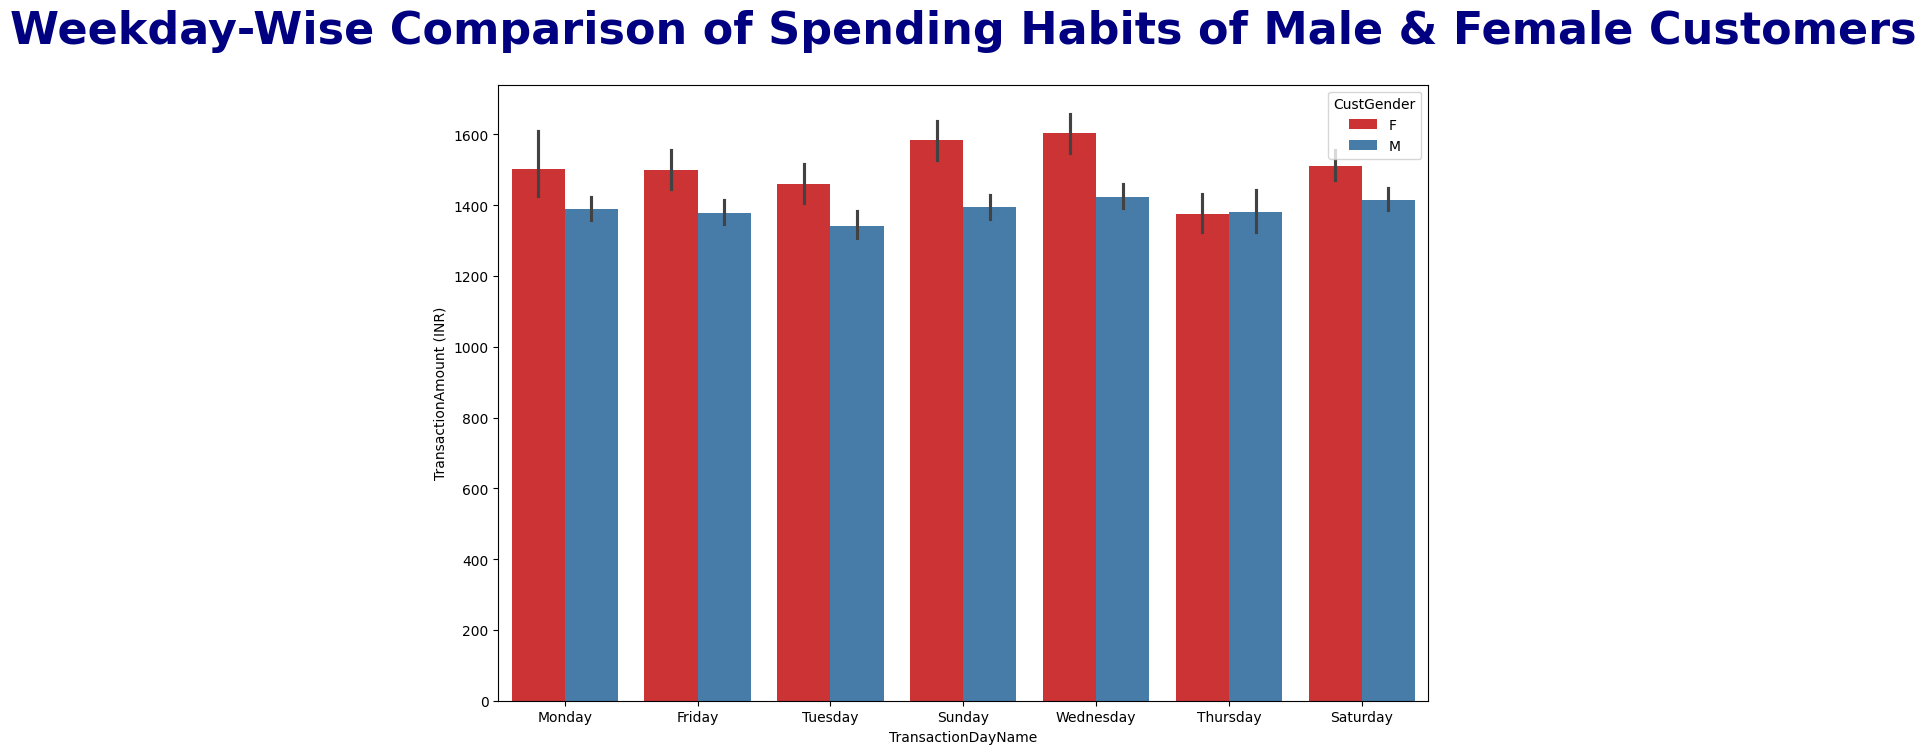

In [43]:
sns.barplot(data=df,x='TransactionDayName',y='TransactionAmount (INR)',palette='Set1',hue='CustGender')
plt.title('Weekday-Wise Comparison of Spending Habits of Male & Female Customers',fontsize=32,fontweight='bold',color='navy',pad=30)

<span style="color: pink;">Female customers perform higher transactions than their male counterparts in almost every week day.</span>

Text(0.5, 1.0, 'Monthly Comparison of Account Balances of Male & Female Customers')

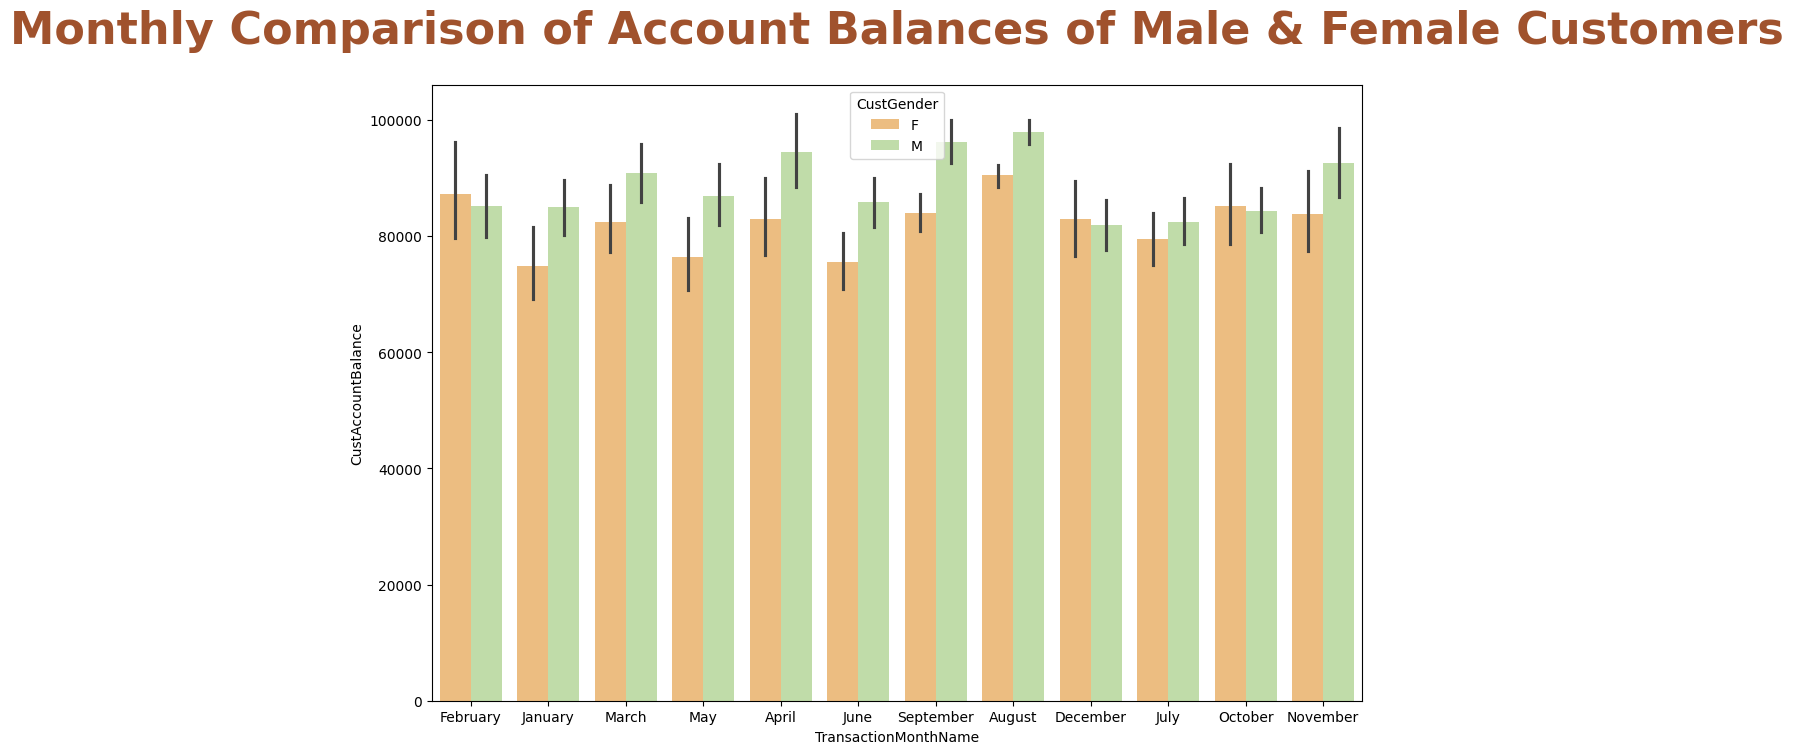

In [44]:
sns.barplot(data=df,x='TransactionMonthName',y='CustAccountBalance',palette='Spectral',hue='CustGender')
plt.title('Monthly Comparison of Account Balances of Male & Female Customers',fontsize=32,fontweight='bold',color='sienna',pad=30)

<span style="color: pink;">Male customers predominantly have greater account balances as compared to their female counterparts. This is evident from the fact that they generally make comparatively low value transactions than female customers.</span>

<Axes: xlabel='TransactionMonthName', ylabel='TransactionAmount (INR)'>

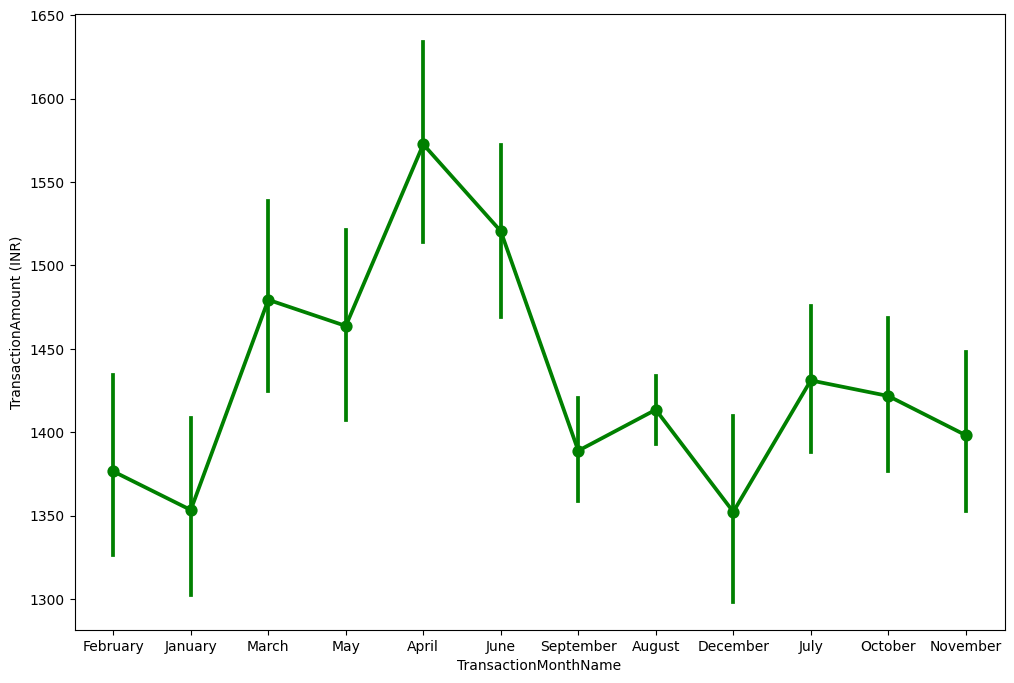

In [45]:
sns.pointplot(data=df,x='TransactionMonthName',y='TransactionAmount (INR)',color='green')

<span style="color: pink;">Highest value transactions are performed during the summer months while least value transactions are made in the winter months.</span>

<Axes: xlabel='TransactionMonthName', ylabel='CustAccountBalance'>

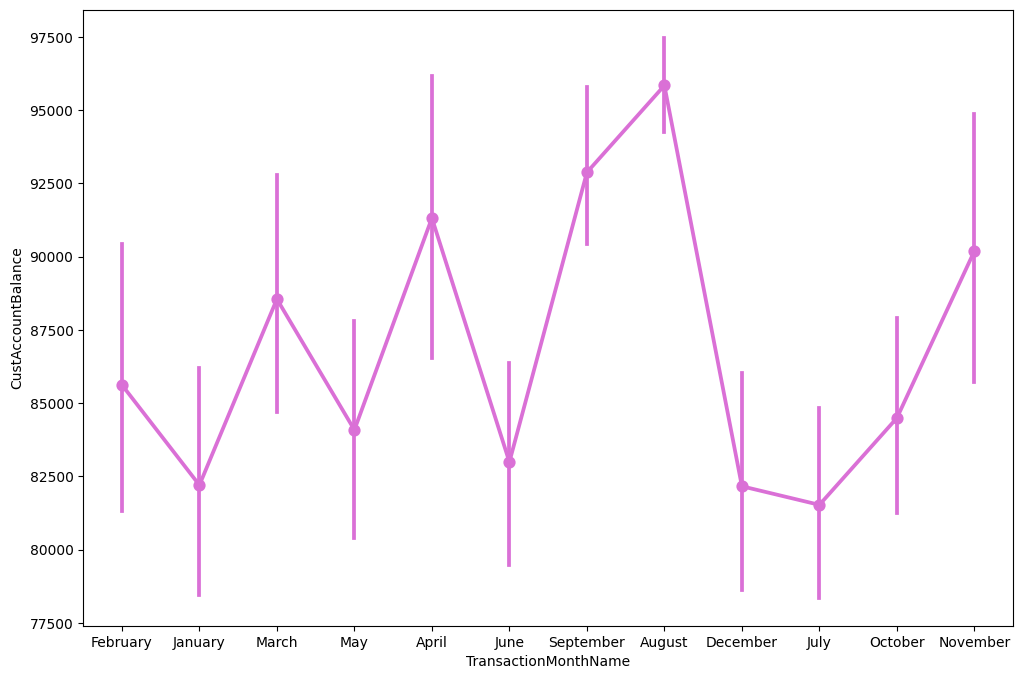

In [46]:
sns.pointplot(data=df,x='TransactionMonthName',y='CustAccountBalance',color='orchid')

<span style="color: pink;">Commonly, the account balances of customers are highest in the months of August and September whereas they are lowest in the months of July and December. In the festive months, the customer account balances drop significantly which makes sense as people usually expend more money during the festive season.</span>

Text(0, 0.5, 'Transaction Amount (INR)')

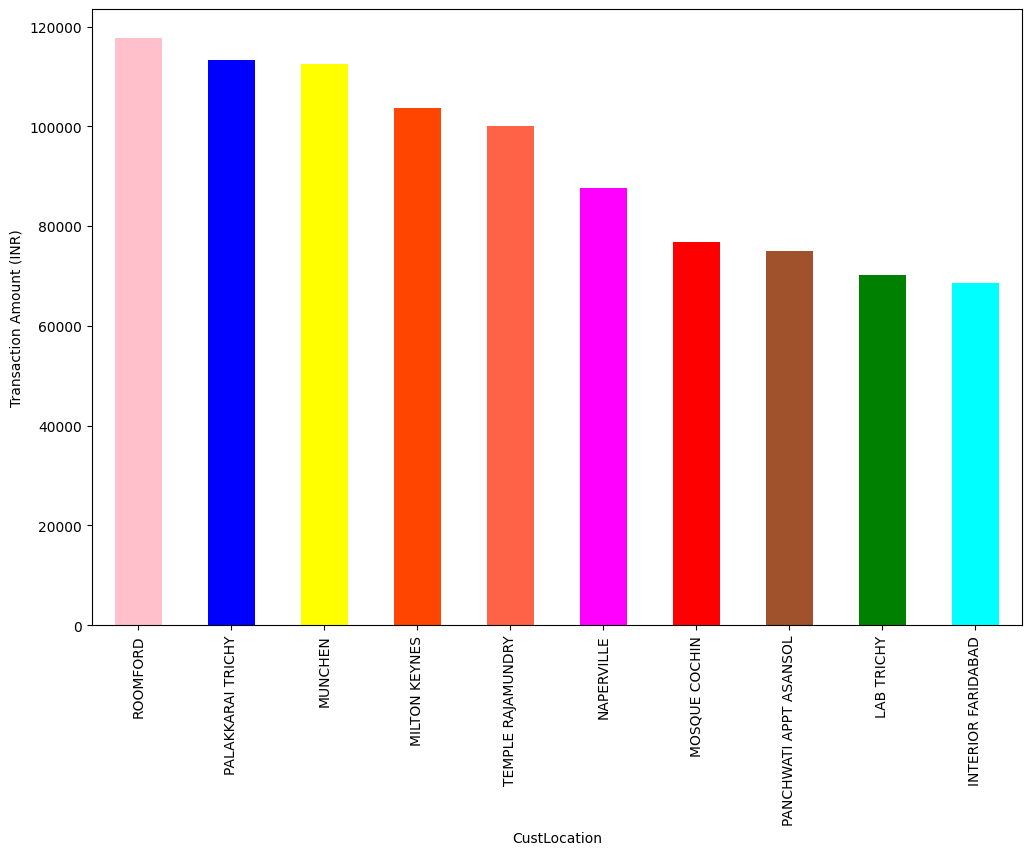

In [47]:
df.groupby('CustLocation')['TransactionAmount (INR)'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['pink','blue','yellow','orangered','tomato','magenta','red','sienna','green','cyan'])
plt.ylabel('Transaction Amount (INR)')

<span style="color: pink;">Customers belonging to the Roomford bank branch in United Kingdom mostly perform the highest transactions which are closely followed by the bank branches in Palakkarai Trichy(Tamil Nadu, India) and Munchen in Germany.</span>

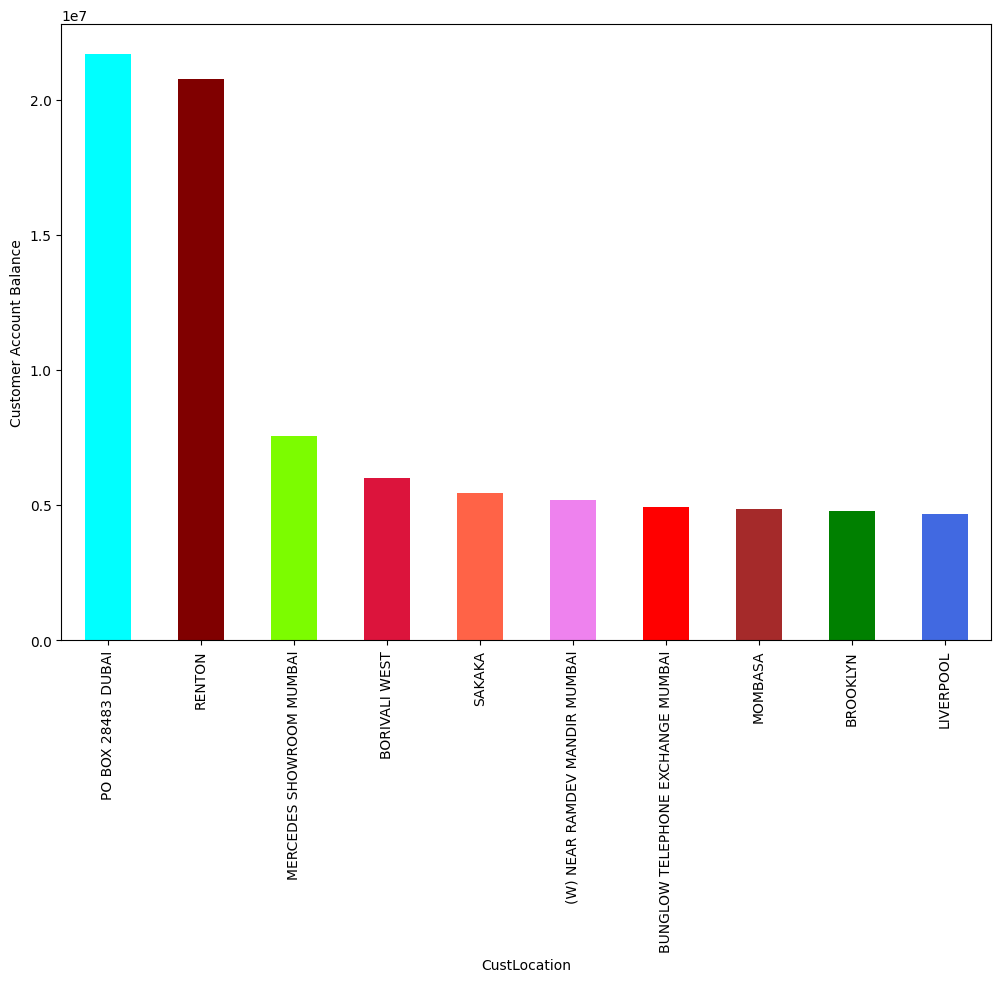

In [48]:
df.groupby('CustLocation')['CustAccountBalance'].mean().sort_values(ascending=False)[:10].plot(kind='bar',color=['aqua','maroon','lawngreen','crimson','tomato','violet','red','brown','green','royalblue'])
plt.ylabel('Customer Account Balance');

<span style="color: pink;">Customers living in PO Box 28483 Dubai bank branch have the highest account balances among all customers.</span>

<Axes: xlabel='Age', ylabel='CustAccountBalance'>

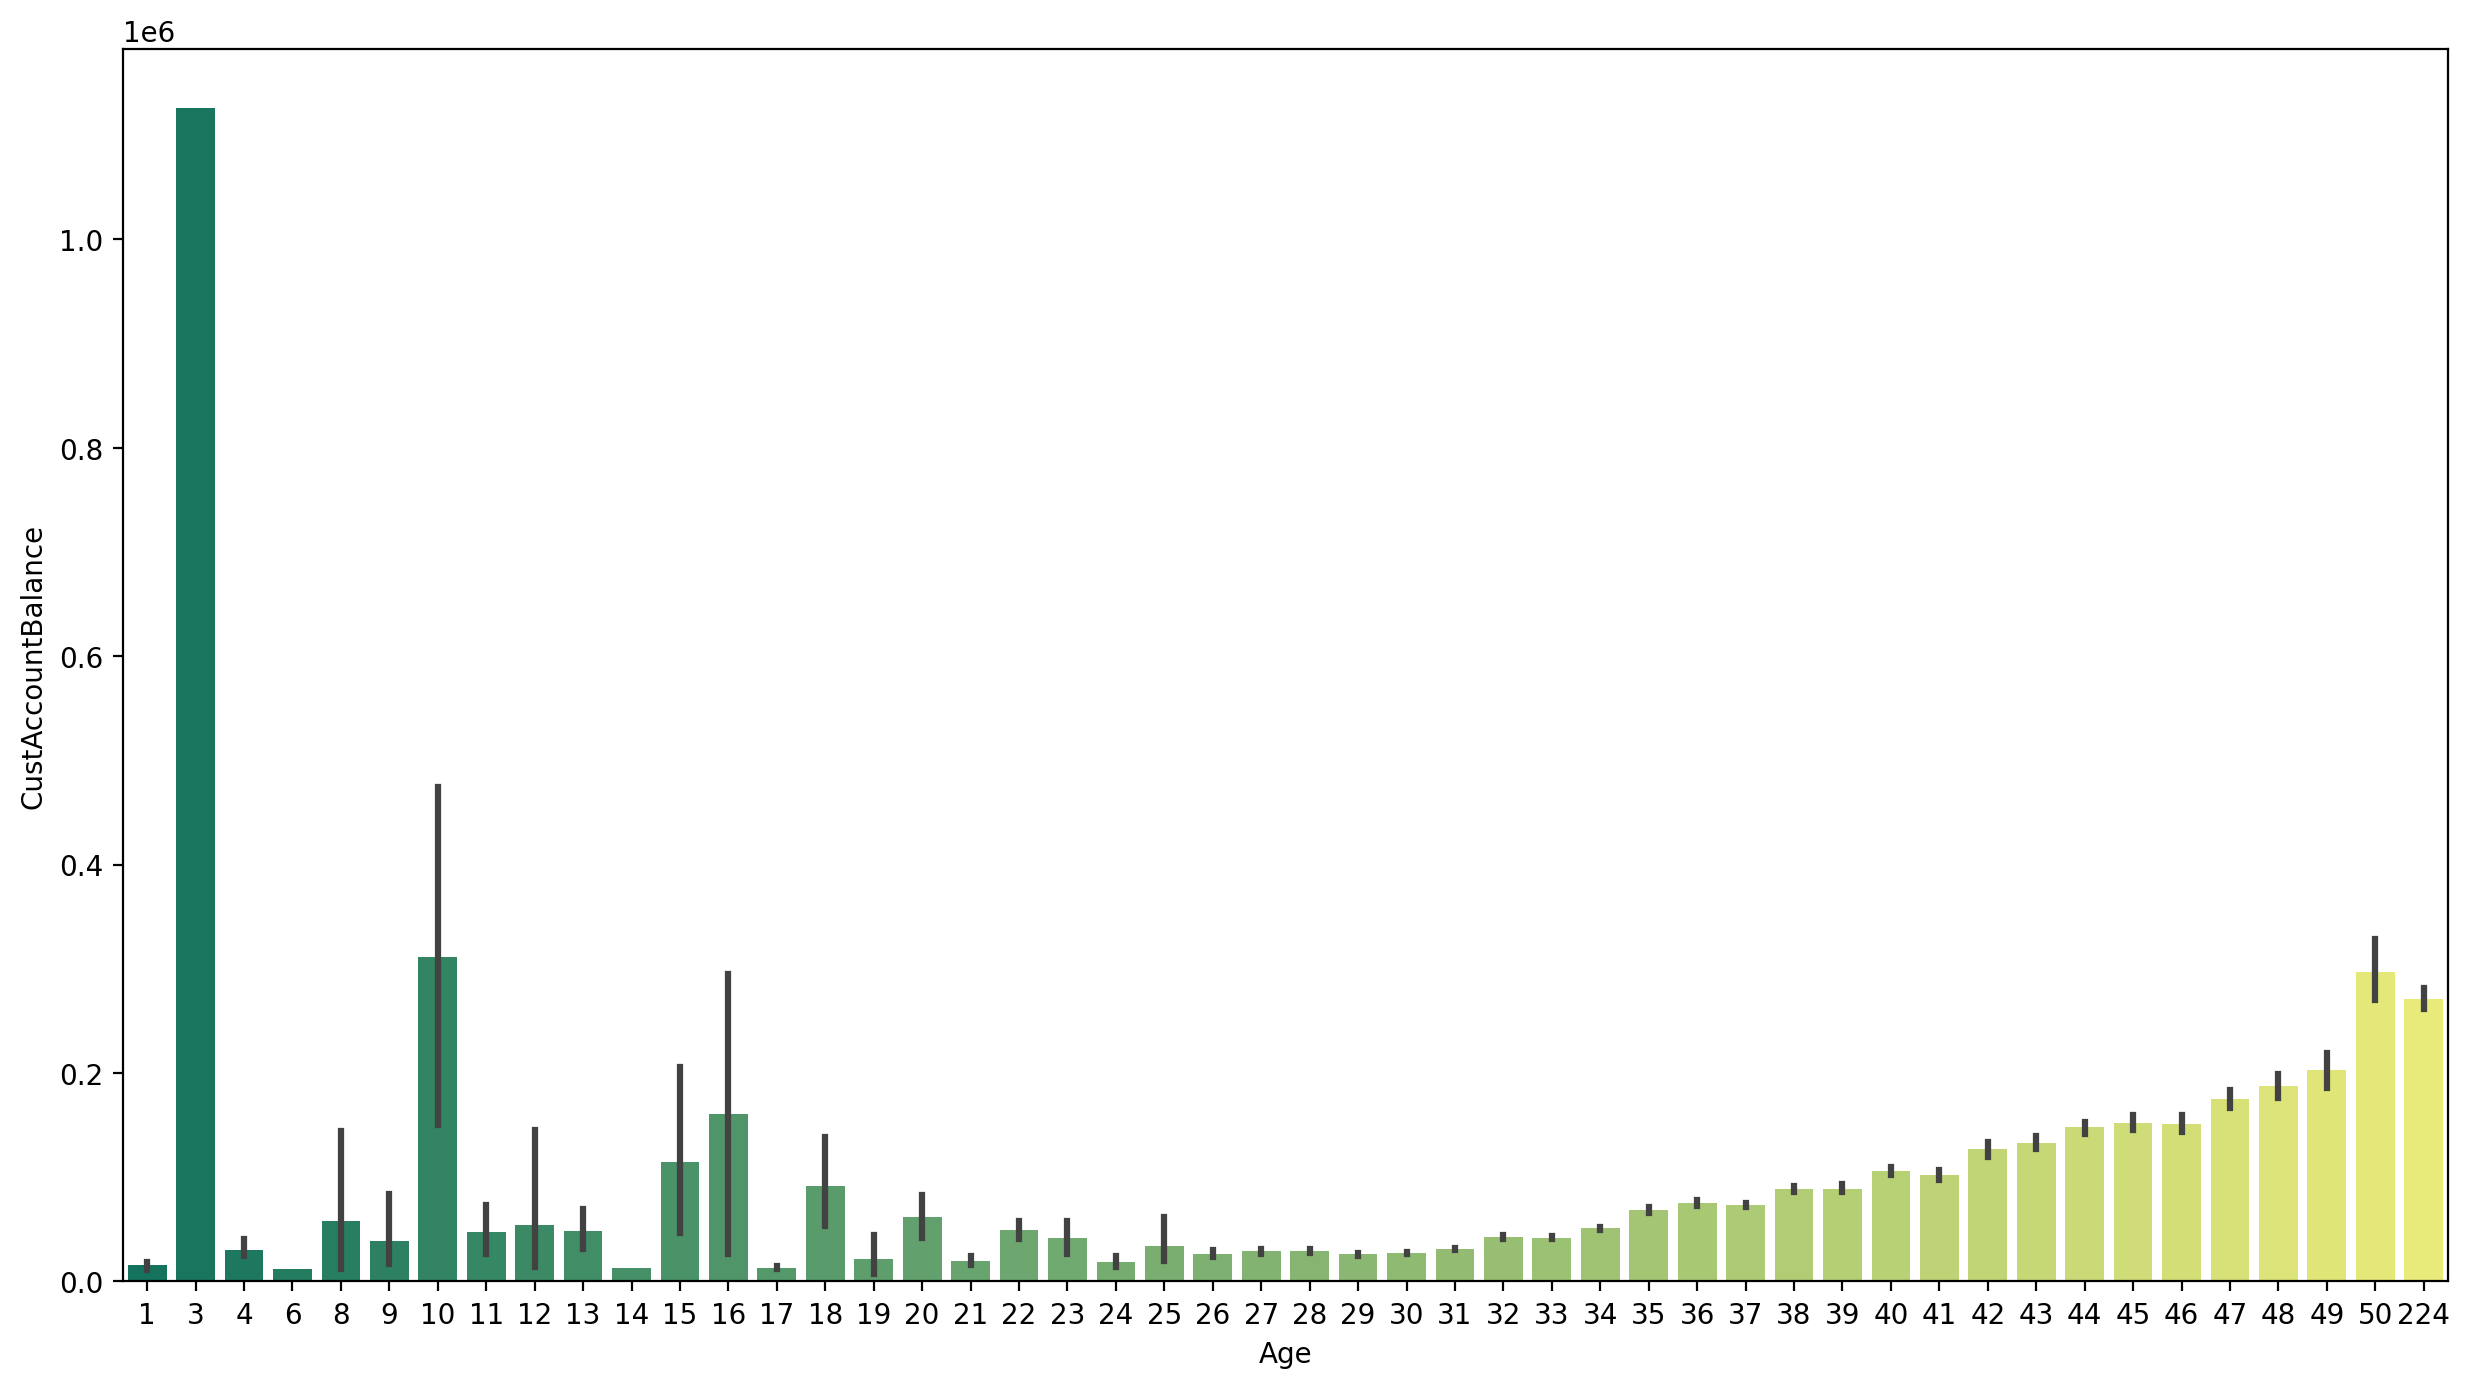

In [49]:
plt.figure(figsize=(15,8),dpi=200)
sns.barplot(data=df,x='Age',y='CustAccountBalance',palette='summer')

<span style="color: pink;">In general, the account balances of customers rise abruptly with increase in their ages, attaining a peak by the old age of 50 years or more, although there are a few excepions to this matter. The account balances of younger adults in the age range of 19 to 22 years have higher account balances in comparison to their surrounding age groups.</span>

<Axes: xlabel='Age', ylabel='TransactionAmount (INR)'>

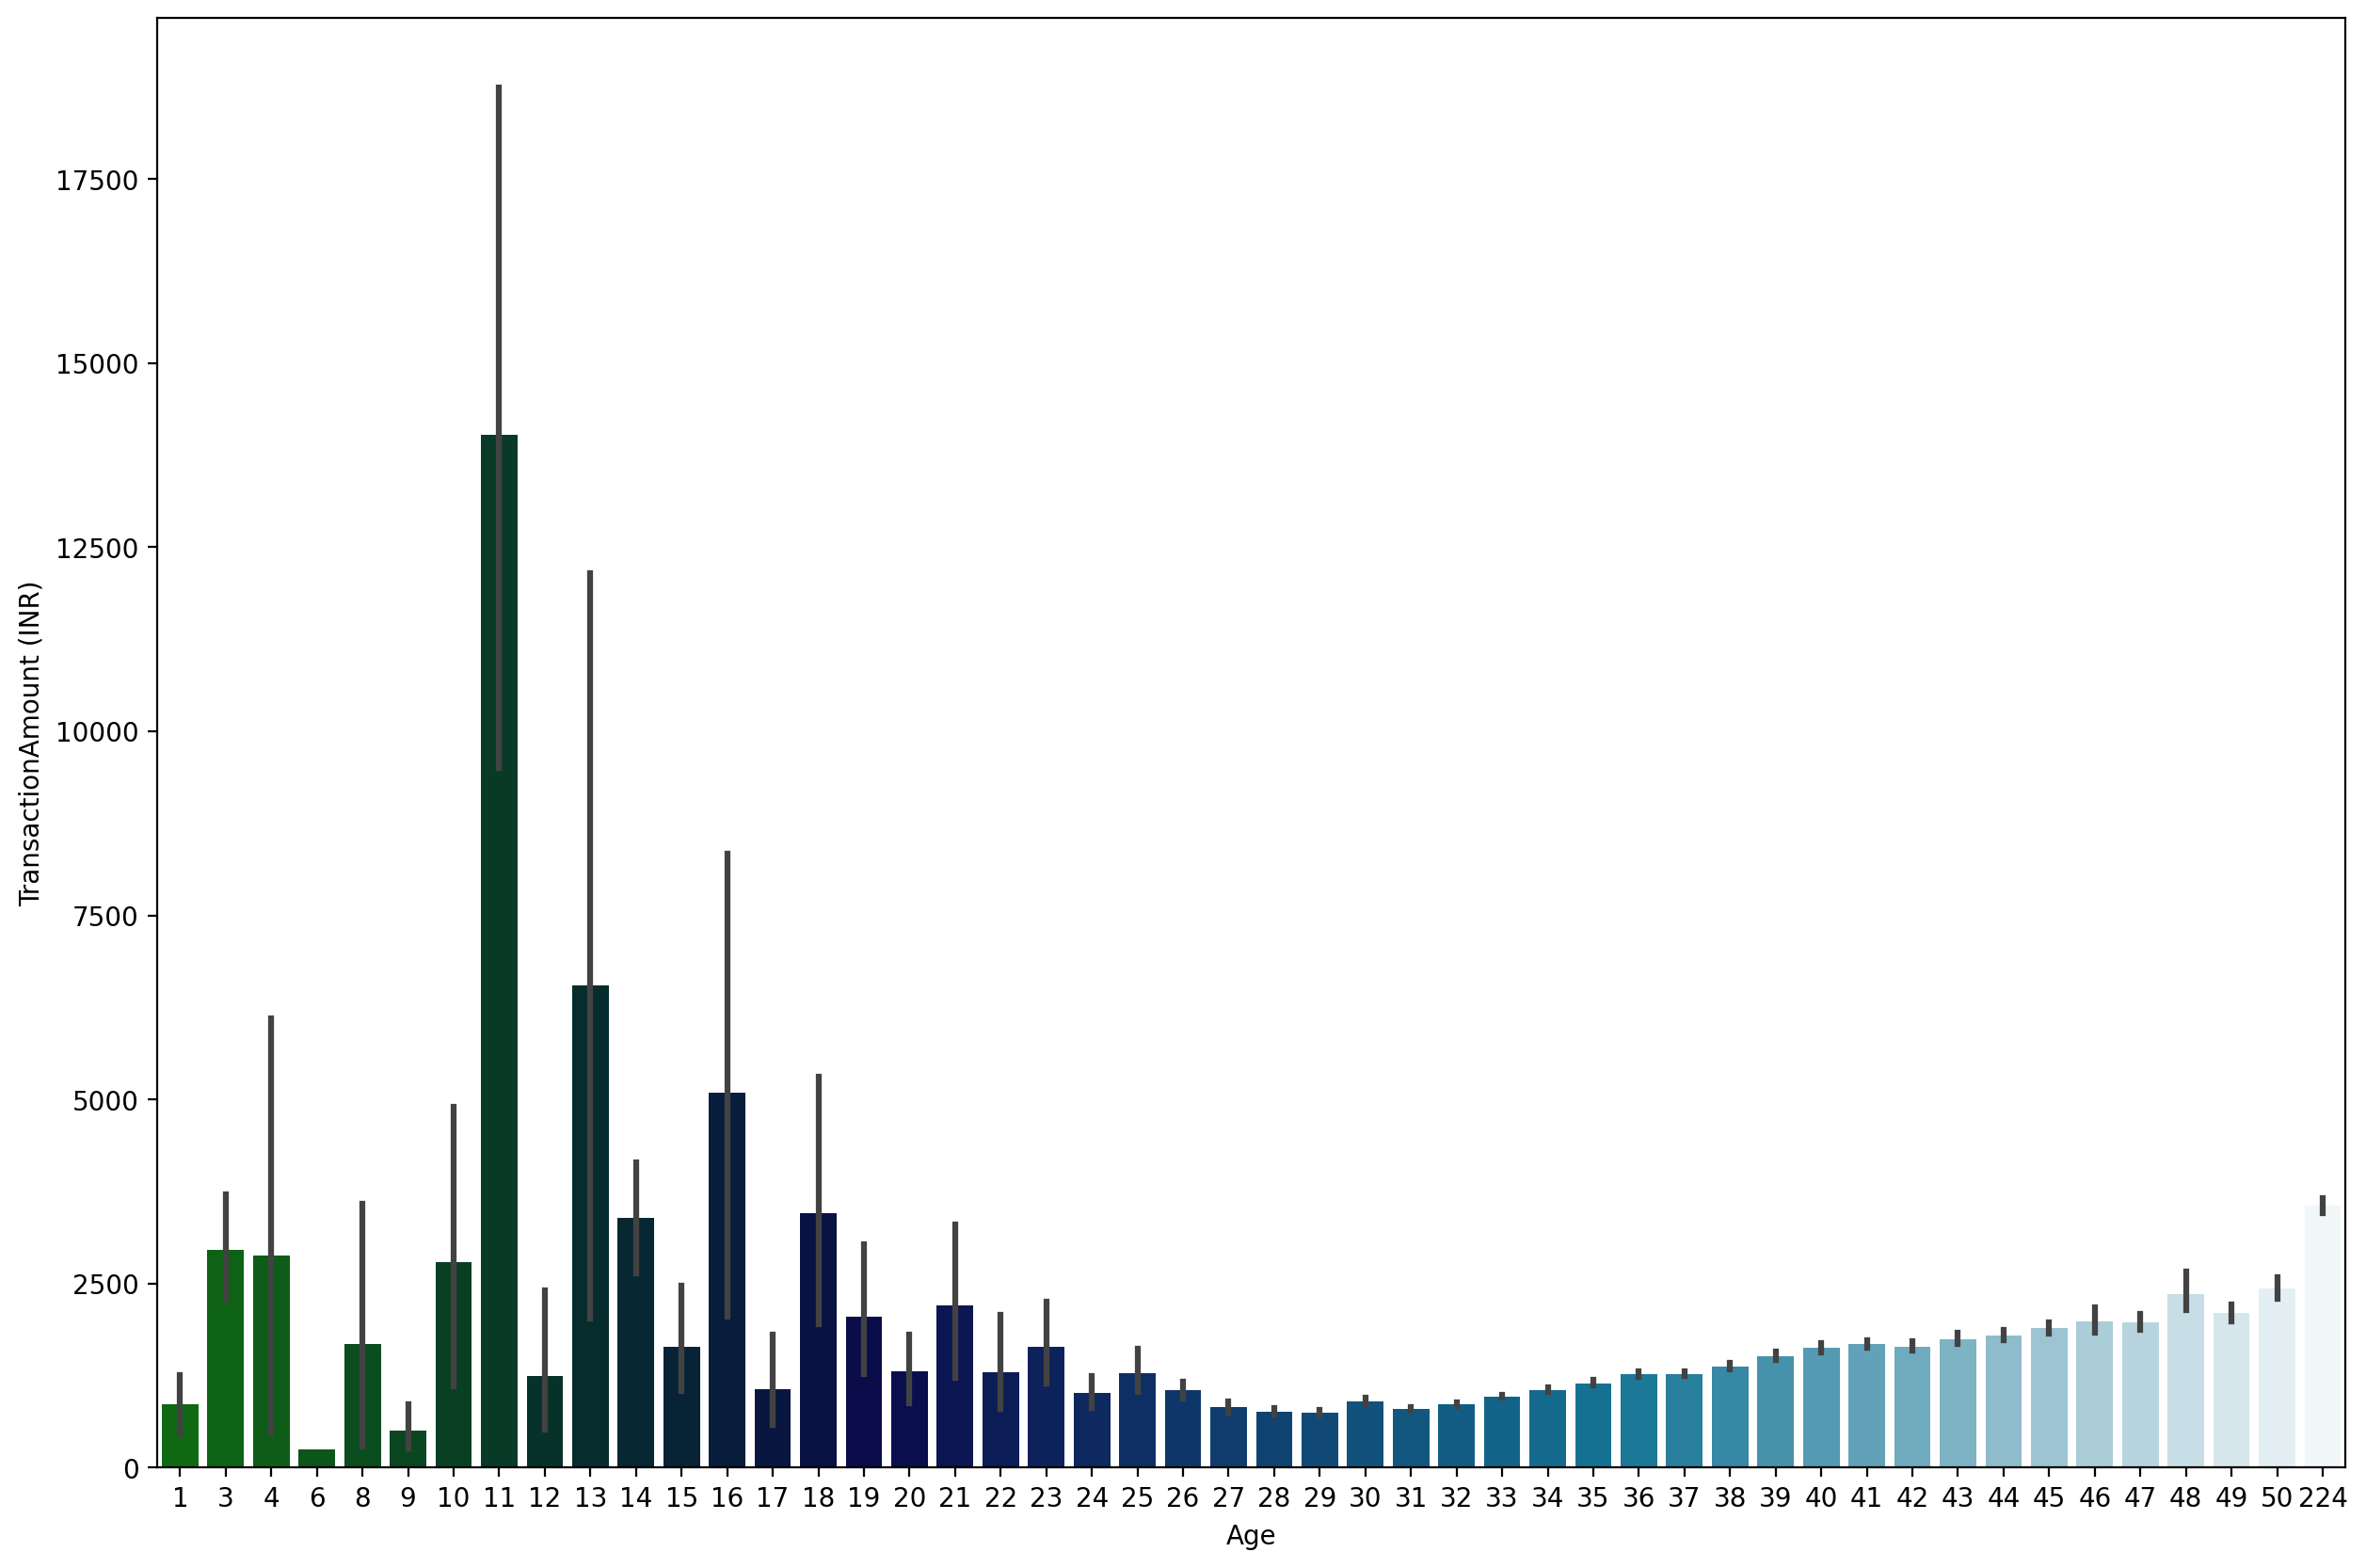

In [50]:
plt.figure(figsize=(15,10),dpi=200)
sns.barplot(data=df,x='Age',y='TransactionAmount (INR)',palette='ocean')

<span style="color: pink;">Likewise, an exactly similar trend prevails in case of transaction amounts as well. Younger adult customers, in the age range of 19 to 24 years, perform exorbitant transactions as compared to their surrounding age groups. This is most probably due to the reason that younger adults between the ages of 18 to 24 years have their own career aspirations to fulfil as a consequence of which they generally have lavish and extravagant demands for fulfilling their passions and interests and for facilitating their development through all means. Nevertheless, middle age senior adults and elderly customers make comparatively more extortionate transactions for managing their families and livelihoods.</span>

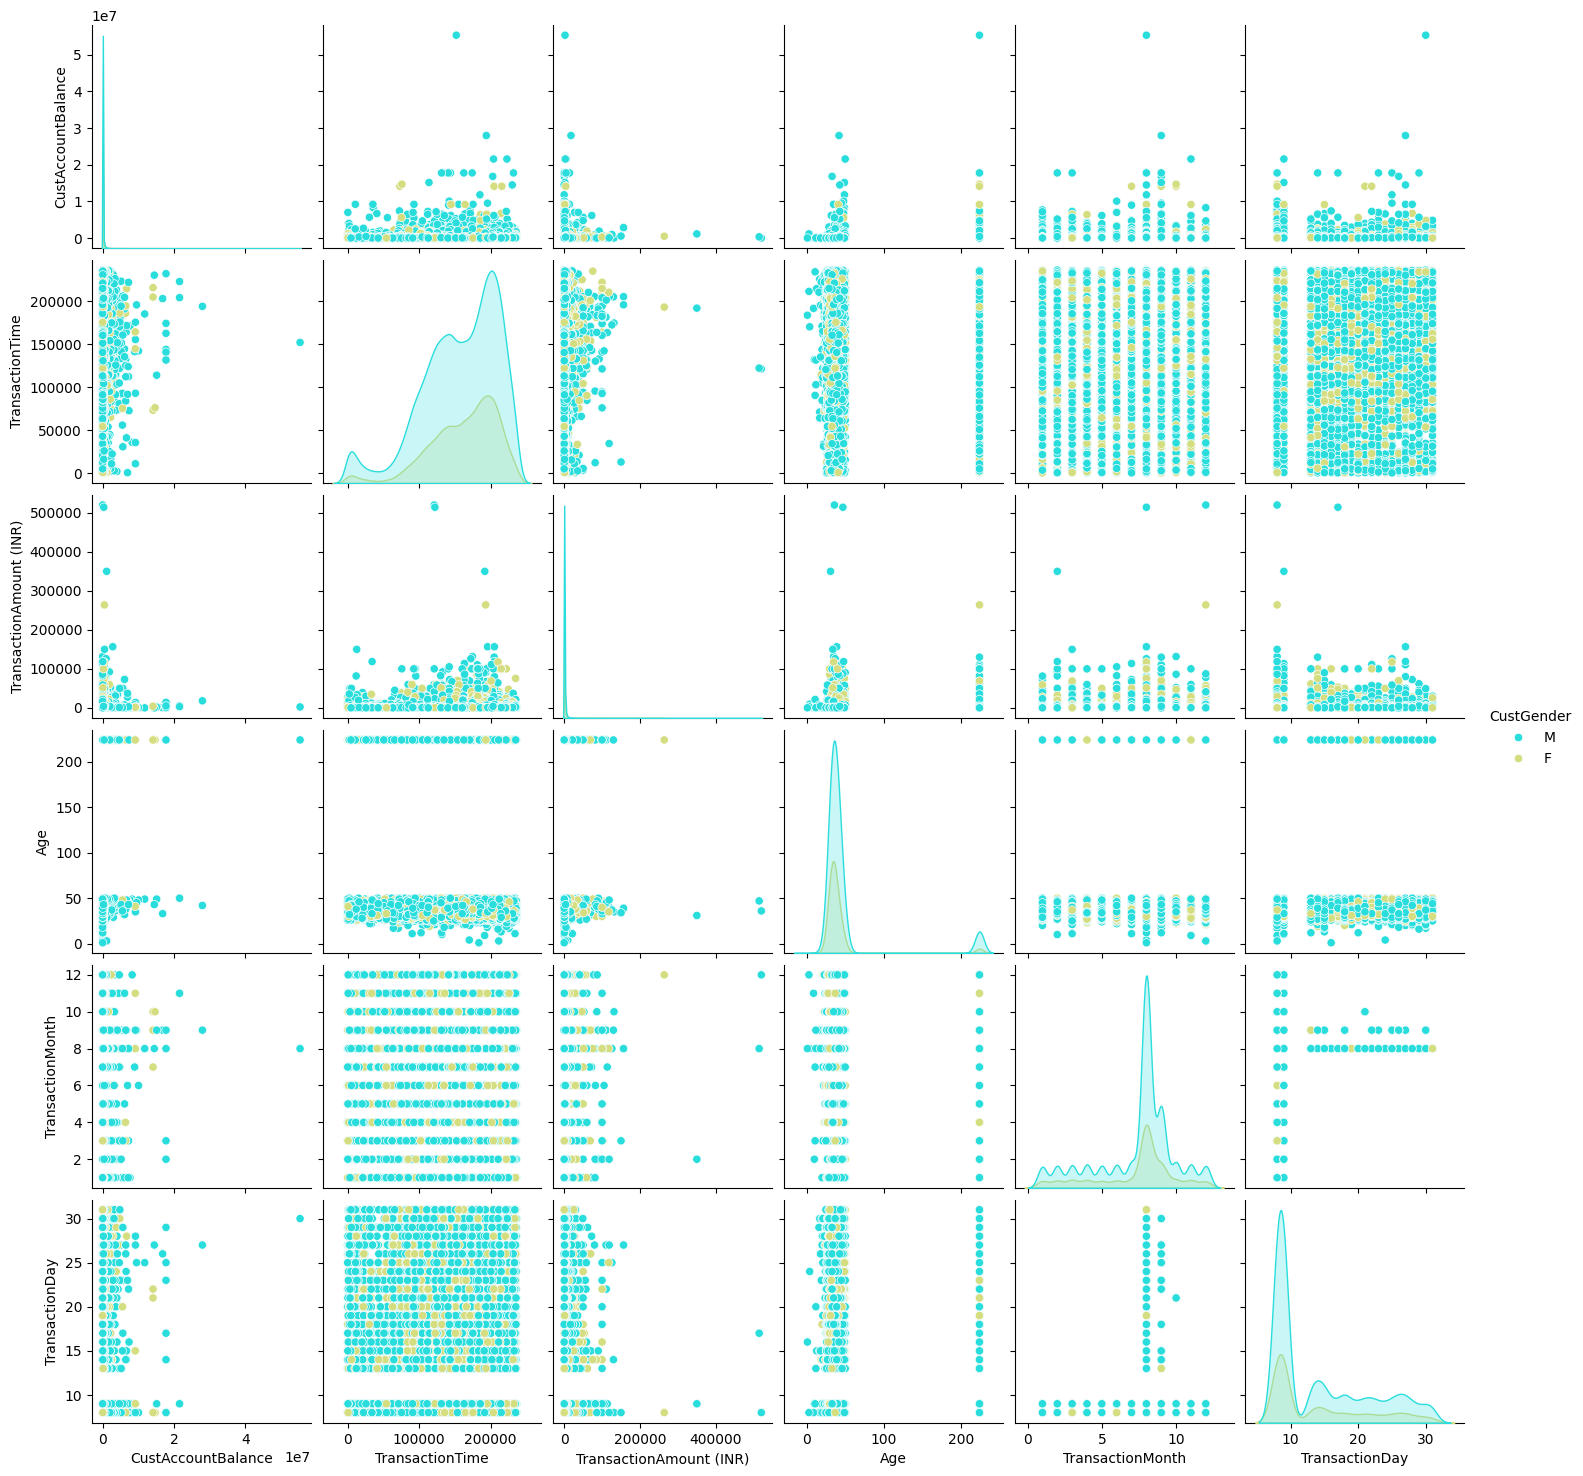

In [51]:
sns.pairplot(df.sample(n=50000),hue='CustGender',palette='rainbow')

In [52]:
df.CustGender.replace(['F','M'],[0,1],inplace=True)
df.CustGender = df.CustGender.astype(np.int64)

#### <span style="color: orange;">Categorical Encoding:</span>

In [53]:
encoder = LabelEncoder()
df.CustLocation = encoder.fit_transform(df.CustLocation)
df.CustLocation = df.CustLocation.astype(np.int64)

In [54]:
df.drop(['TransactionMonthName','TransactionDayName'],axis=1,inplace=True)

#### <span style="color: orange;">Feature Scaling:</span>

In [55]:
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df,columns=df.columns)
scaled_df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,-1.65,-0.22,-0.15,-0.27,-0.23,-0.42,-2.03,-0.88
1,-1.65,0.48,-0.15,-0.28,-0.16,-0.46,-2.03,-0.88
2,-1.65,0.64,-0.18,0.46,0.06,-0.26,-2.03,-0.88
3,-1.65,0.48,-0.19,0.32,-0.14,-0.35,-2.03,-0.88
4,0.61,0.48,0.01,0.26,-0.21,-0.13,-2.03,-0.88


## <span style="color: orange;">Unsupervised Machine Learning:</span>

In [56]:
temp = scaled_df.sample(n=50000)

### <span style="color: orange;">K Means Clustering:</span>

In [57]:
base_kmeans = KMeans(random_state=101)
base_kmeans.fit(temp)

KMeans(random_state=101)

In [58]:
labels = set(base_kmeans.labels_)
labels

{0, 1, 2, 3, 4, 5, 6, 7}

In [59]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 21.31%


In [60]:
for i in range(1,11):
    for init in ['k-means++','random']:
        for algo in ['lloyd','elkan']:
            kmeans = KMeans(n_clusters=i,init=init,algorithm=algo,random_state=101)
            kmeans.fit(temp)
            print("Number of Clusters: {}".format(i))
            print("Initialization Algorithm: {}".format(init))
            print("Algorithm: {}".format(algo))
            print("Sum of Squared Distance: %d" % kmeans.inertia_)
            print('-----------------')

Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: lloyd
Sum of Squared Distance: 412037
-----------------
Number of Clusters: 1
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 412037
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: lloyd
Sum of Squared Distance: 412037
-----------------
Number of Clusters: 1
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 412037
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: lloyd
Sum of Squared Distance: 363465
-----------------
Number of Clusters: 2
Initialization Algorithm: k-means++
Algorithm: elkan
Sum of Squared Distance: 363465
-----------------
Number of Clusters: 2
Initialization Algorithm: random
Algorithm: lloyd
Sum of Squared Distance: 361199
-----------------
Number of Clusters: 2
Initialization Algorithm: random
Algorithm: elkan
Sum of Squared Distance: 361199
-----------------
Number of Cl

In [61]:
optimized_kmeans = KMeans(n_clusters=10,init='k-means++',algorithm='elkan',random_state=101)
optimized_kmeans.fit(temp)
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_kmeans.labels_)*100,2)) + '%')

Silhouette Score: 22.11%


In [62]:
print("Estimated number of clusters:", len(set(optimized_kmeans.labels_)), set(optimized_kmeans.labels_))
print("Estimated number of noise points:", list(optimized_kmeans.labels_).count(-1))

Estimated number of clusters: 10 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Estimated number of noise points: 0


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

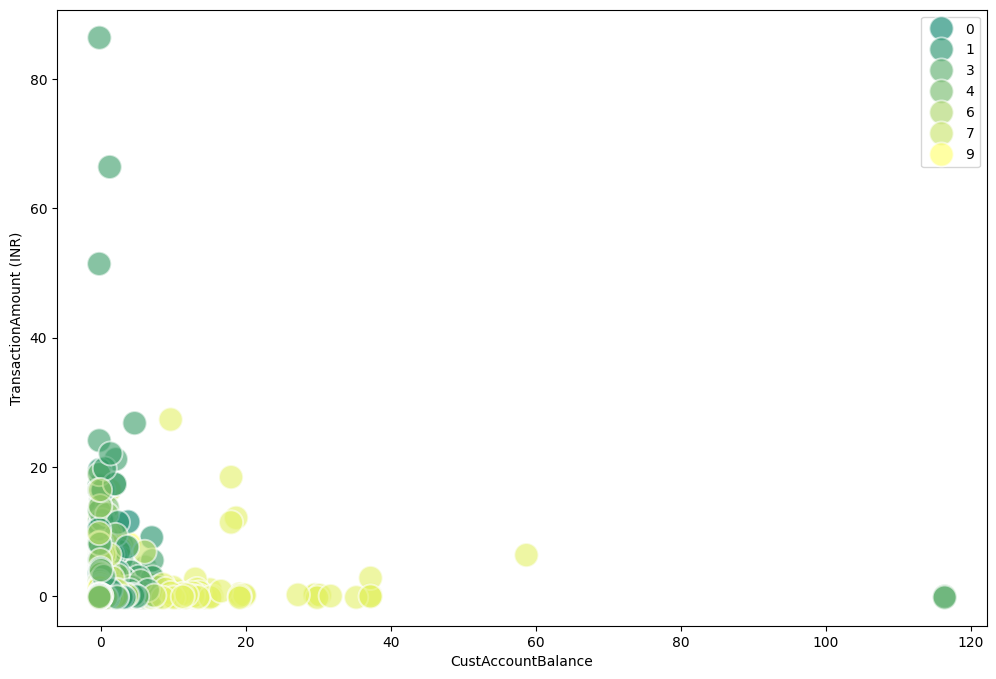

In [63]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_kmeans.labels_,s=300,alpha=0.6,palette='summer')

In [64]:
ce = clusteval(cluster='kmeans',savemem=True,verbose=4)
results = ce.fit(np.reshape(np.ravel(temp.sample(5000)),(-1,1)))
cluster_labels = results['labx']

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO> Save memory enabled for kmeans with evaluation silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [05:06<00:00, 13.32s/it]
[clusteval] >DEBUG> [[ 0  1  0 ...  1  0  0]
 [ 2  2  1 ...  0  1  1]
 [ 2  2  1 ...  2  1  0]
 ...
 [ 4  1 17 ...  3  8  5]
 [ 0  9  5 ... 16 11  6]
 [ 3 11  0 ...  5 13  6]]
[clusteval] >DEBUG> Iloc: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[clusteval] >DEBUG> silscores: [0.55809996 0.56288039 0.58082633 0.61501849 0.55293836 0.60976849
 0.66682872 0.63586736 0.61742208 0.61422796 0.6358903  0.6447937
 0.62020904 0.61402018 0.6030686  0.65880031 0.61215946 0.63008099
 0.62449044 0.63837248 0.62155137 0.60480693 0.68089239]
[clusteval] >DEBUG> sillclust: [ 2.  3.  4.  5.  6.  7. 

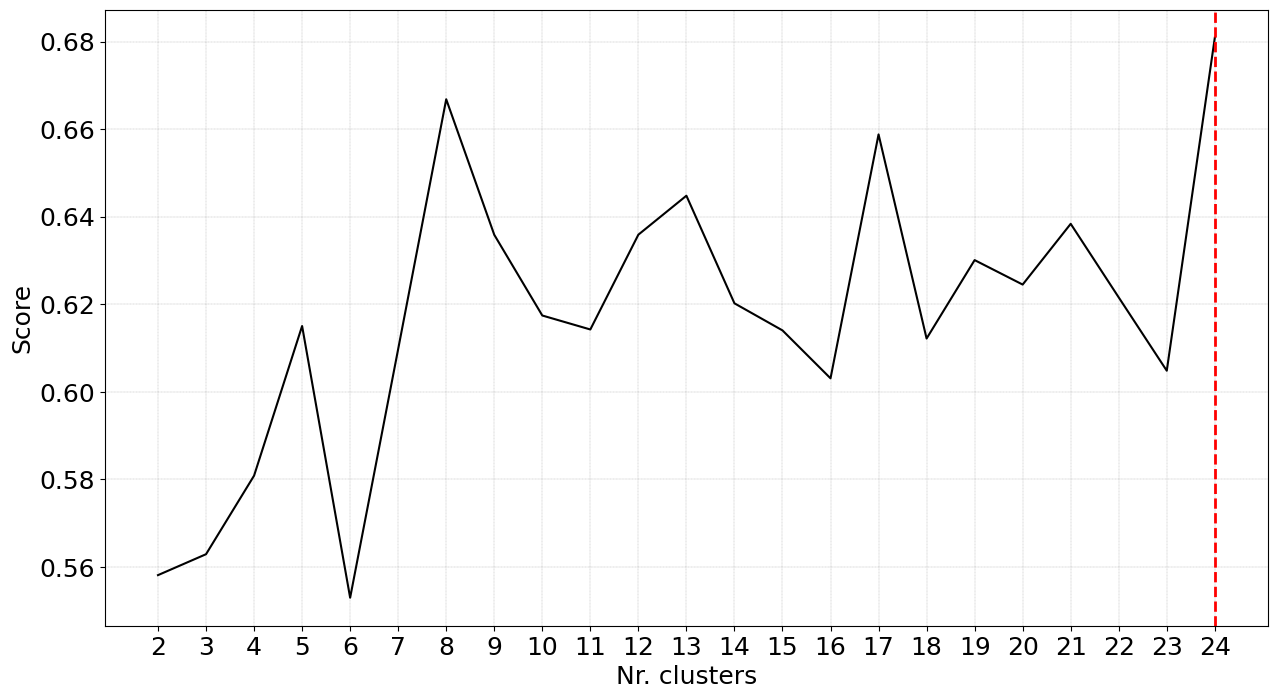

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [65]:
ce.plot()

### <span style="color: orange;">Hierarchical Clustering:</span>

In [66]:
mmscaler = MinMaxScaler()
minmax_scaled_df = mmscaler.fit_transform(df)
minmax_scaled_df = pd.DataFrame(minmax_scaled_df,columns=df.columns)
minmax_scaled_df.head()

,CustGender,CustLocation,CustAccountBalance,TransactionTime,TransactionAmount (INR),Age,TransactionMonth,TransactionDay
0,0.00,0.38,0.00,0.61,0.00,0.13,0.09,0.00
1,0.00,0.56,0.00,0.60,0.00,0.12,0.09,0.00
2,0.00,0.60,0.00,0.77,0.00,0.16,0.09,0.00
3,0.00,0.56,0.00,0.74,0.00,0.14,0.09,0.00
4,1.00,0.56,0.00,0.72,0.00,0.18,0.09,0.00


In [67]:
temp2 = minmax_scaled_df.sample(n=50000)

In [68]:
base_hc = AgglomerativeClustering()
base_hc.fit(temp2)

AgglomerativeClustering()

In [69]:
print("Estimated number of clusters:", set(base_hc.labels_))

Estimated number of clusters: {0, 1}


In [70]:
print("Estimated number of noise points:", list(base_hc.labels_).count(-1))

Estimated number of noise points: 0


In [71]:
print("Silhouette Score:",str(np.round(silhouette_score(temp2,base_hc.labels_)*100,2)) + '%')

Silhouette Score: 41.87%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

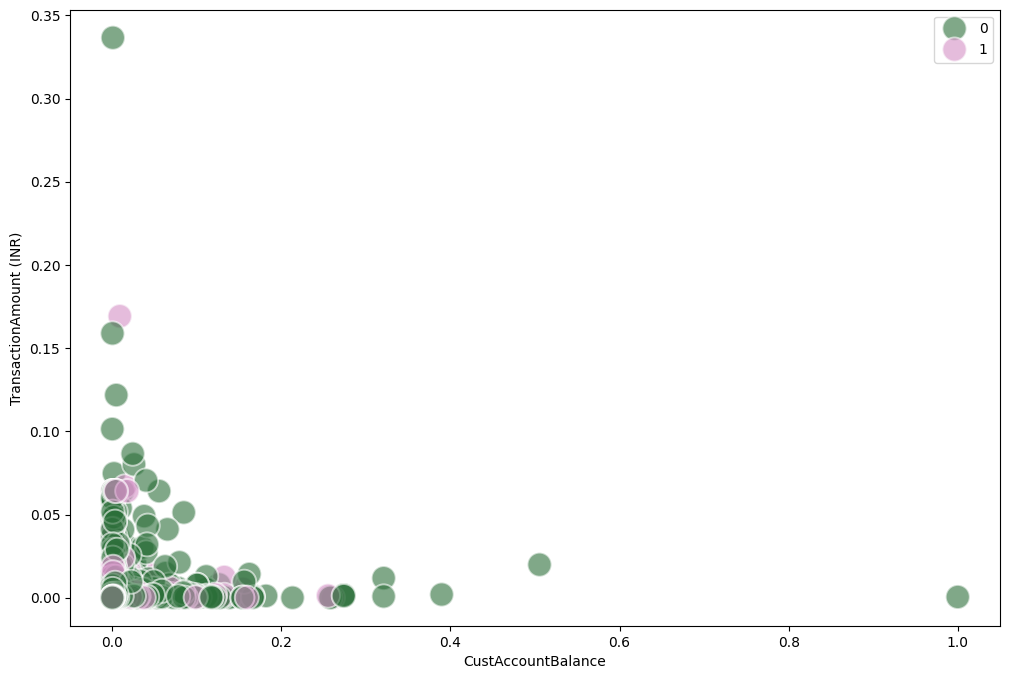

In [72]:
sns.scatterplot(x='CustAccountBalance', y='TransactionAmount (INR)', data=temp2, hue=base_hc.labels_, s=300, alpha=0.6, palette='cubehelix')

In [73]:
temp2_samp = temp2.sample(500)
ce = clusteval(verbose=4)
results = ce.fit(np.reshape(np.ravel(temp2_samp),(-1,1)))
results

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[agglomerative], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO: 100%|██████████| 23/23 [00:03<00:00,  6.65it/s]
[clusteval] >DEBUG> [[ 2  2  1 ...  1  2  1]
 [ 2  3  1 ...  1  2  1]
 [ 3  4  1 ...  2  3  1]
 ...
 [11 17  1 ...  4 12  3]
 [12 18  1 ...  4 13  3]
 [13 19  1 ...  4 14  3]]
[clusteval] >DEBUG> Iloc: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
[clusteval] >DEBUG> silscores: [0.75201408 0.71250707 0.71050627 0.73397657 0.75790327 0.74921107
 0.76589315 0.76082411 0.77281416 0.77195849 0.75660368 0.76087228
 0.76043709 0.76499827 0.76736516 0.78143052 0.78808196 0.79171
 0.79469347 0.80007574 0.81054033 0.81192512 0.80685801]
[clusteval] >DEBUG> sillclust: [ 2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19.
 20. 21. 22. 23. 24.]
[cl

{'evaluate': 'silhouette',
 'score':     cluster_threshold  clusters  score
 0                   2         2   0.75
 1                   3         3   0.71
 2                   4         4   0.71
 3                   5         5   0.73
 4                   6         6   0.76
 5                   7         7   0.75
 6                   8         8   0.77
 7                   9         9   0.76
 8                  10        10   0.77
 9                  11        11   0.77
 10                 12        12   0.76
 11                 13        13   0.76
 12                 14        14   0.76
 13                 15        15   0.76
 14                 16        16   0.77
 15                 17        17   0.78
 16                 18        18   0.79
 17                 19        19   0.79
 18                 20        20   0.79
 19                 21        21   0.80
 20                 22        22   0.81
 21                 23        23   0.81
 22                 24        24   0.81,
 'l

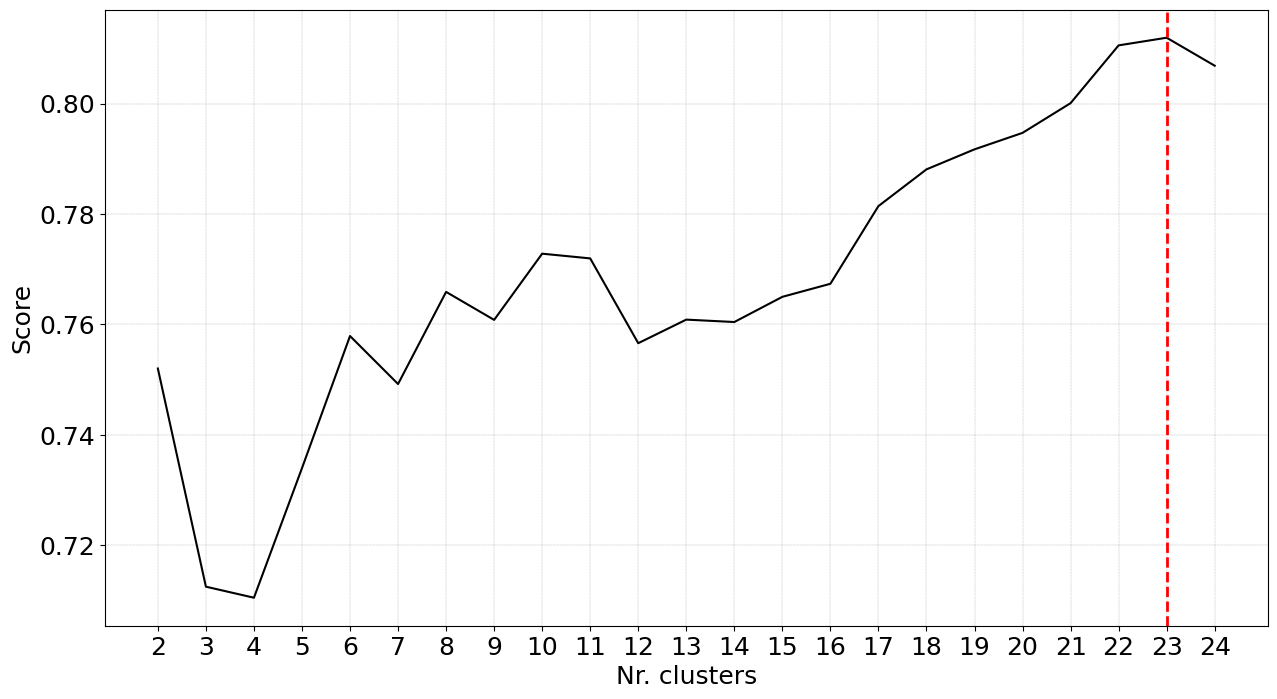

(<Figure size 1500x800 with 1 Axes>,
 <Axes: xlabel='Nr. clusters', ylabel='Score'>)

In [74]:
ce.plot()

### <span style="color: orange;">Density-based Spatial Clustering with Applications with Noise (DBSCAN):</span>

In [75]:
base_dbscan = DBSCAN()
base_dbscan.fit(temp)

DBSCAN()

In [76]:
print("Estimated number of clusters:", set(base_dbscan.labels_))

Estimated number of clusters: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, -1}


In [77]:
print("Estimated number of noise points:", list(base_dbscan.labels_).count(-1))

Estimated number of noise points: 4428


In [78]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_dbscan.labels_)*100,2)) + '%')

Silhouette Score: -17.83%


In [79]:
def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)
    distances, indices = nbrs.kneighbors(X)                          
    distances = np.sort(distances[:,k-1], axis=0)
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.show()
    return distances[knee.knee]

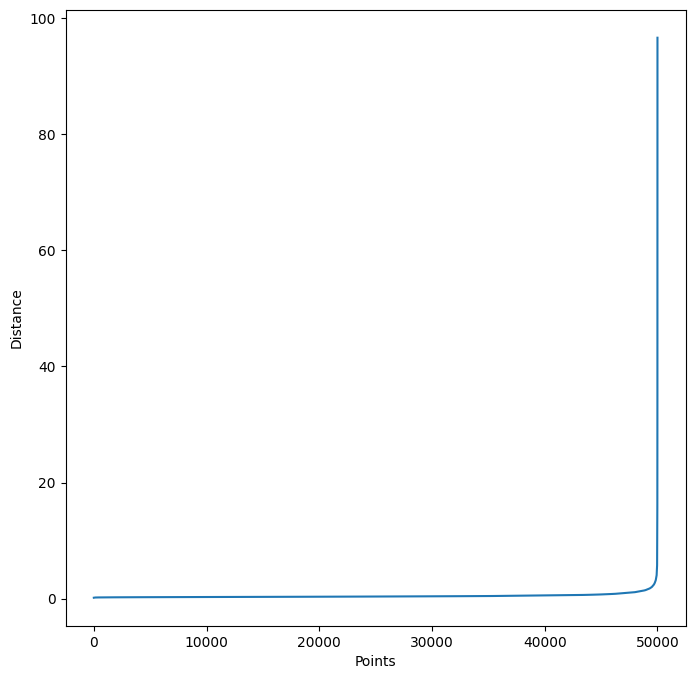

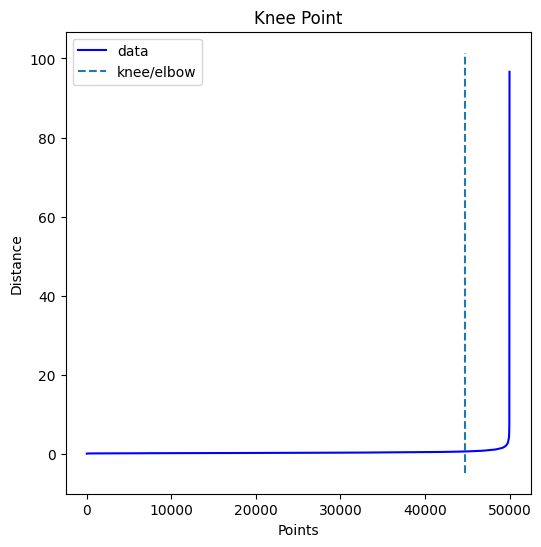

Knee Point: 0.7021787758522614


In [80]:
k = 2 * temp.shape[-1] 
x = get_kdist_plot(temp,k)
print("Knee Point:",x)

In [81]:
ms = np.arange(3,2*temp.shape[1],3)
silhouette_scores = []

for i in ms:
    dbscan = DBSCAN(eps=x,min_samples=i)
    dbscan.fit(temp)
    silhouette_scores.append(silhouette_score(temp,dbscan.labels_))
    print("{} Minimum Samples Tested!".format(i))

3 Minimum Samples Tested!
6 Minimum Samples Tested!
9 Minimum Samples Tested!
12 Minimum Samples Tested!
15 Minimum Samples Tested!


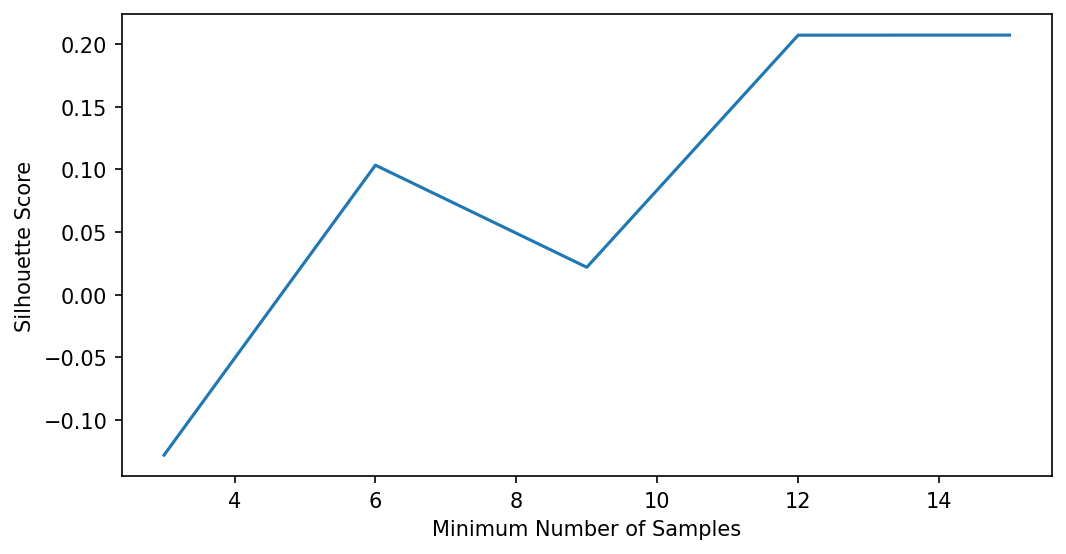

In [82]:
plt.figure(figsize=(8,4), dpi=150)
sns.lineplot(x=ms, y=silhouette_scores)
plt.xlabel('Minimum Number of Samples')
plt.ylabel('Silhouette Score')
plt.show()

In [83]:
optimized_dbscan = DBSCAN(eps=x,min_samples=11)
optimized_dbscan.fit(temp)

DBSCAN(eps=0.7021787758522614, min_samples=11)

In [84]:
print("Estimated number of clusters:",set(optimized_dbscan.labels_))

Estimated number of clusters: {0, 1, 2, 3, -1}


In [85]:
print("Estimated number of noise points:",list(optimized_dbscan.labels_).count(-1))

Estimated number of noise points: 2893


In [86]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,optimized_dbscan.labels_)*100,2)) + '%')

Silhouette Score: 20.77%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

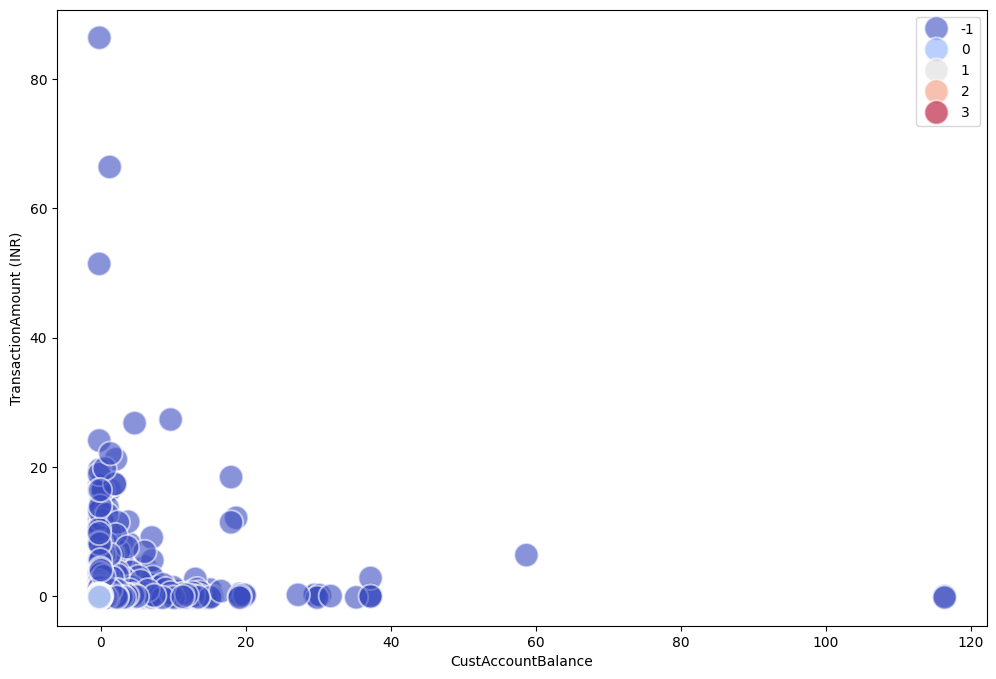

In [87]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=optimized_dbscan.labels_,s=300,alpha=0.6,palette='coolwarm')

In [88]:
enhanced_dbscan = DBSCAN(eps=3,min_samples=2*temp.shape[1])
enhanced_dbscan.fit(temp)

DBSCAN(eps=3, min_samples=16)

In [89]:
print("Estimated number of clusters:",len(set(enhanced_dbscan.labels_)),set(enhanced_dbscan.labels_))

Estimated number of clusters: 4 {0, 1, 2, -1}


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

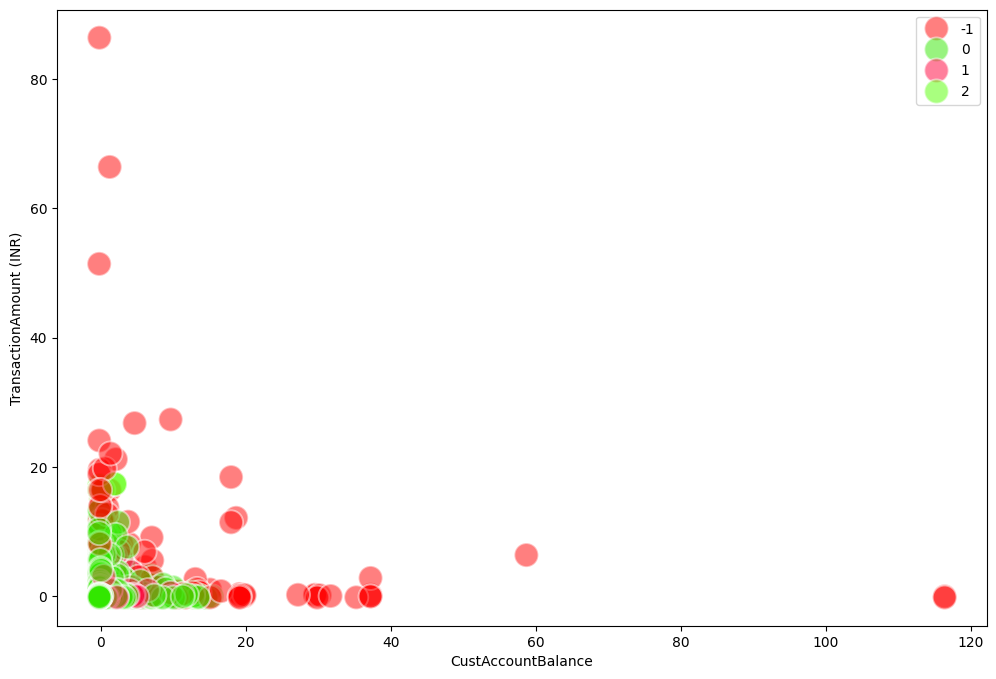

In [90]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=enhanced_dbscan.labels_,palette='prism',s=300,alpha=0.5)

In [91]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,enhanced_dbscan.labels_)*100,2)) + '%')

Silhouette Score: 41.5%


<span style="color: pink;">The optimized DBSCAN model has classified the entire population of customers primarily into two major groups, one of them consists of all those customers who have modest account balance and make low-value transactions whereas the miscellaneous group includes either the customers who have high account balances and spend very less money through transactions or those who have minimal account balance but expend a large amount of cash through high-value transactions.</span>

### <span style="color: orange;">Principal Component Analysis (PCA):</span>

In [92]:
temp = scaled_df.sample(20000)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(temp)
pca_components = pd.DataFrame(pca_components,columns=['PC1','PC2'])
pca_components.head()

,PC1,PC2
0,0.49,-0.16
1,0.21,0.08
2,0.30,0.79
3,-1.71,1.55
4,0.37,-0.40


In [93]:
base_spectral = SpectralClustering(random_state=101)

In [94]:
base_spectral.fit(pca_components)

SpectralClustering(random_state=101)

In [95]:
print("Estimated number of clusters:",len(set(base_spectral.labels_)))
print("Clusters:",set(base_spectral.labels_))

Estimated number of clusters: 8
Clusters: {0, 1, 2, 3, 4, 5, 6, 7}


In [96]:
pca_components['Cluster'] = base_spectral.labels_
print("Silhouette Score:",str(np.round(silhouette_score(pca_components,pca_components.Cluster)*100,2)) + '%')

Silhouette Score: 63.11%


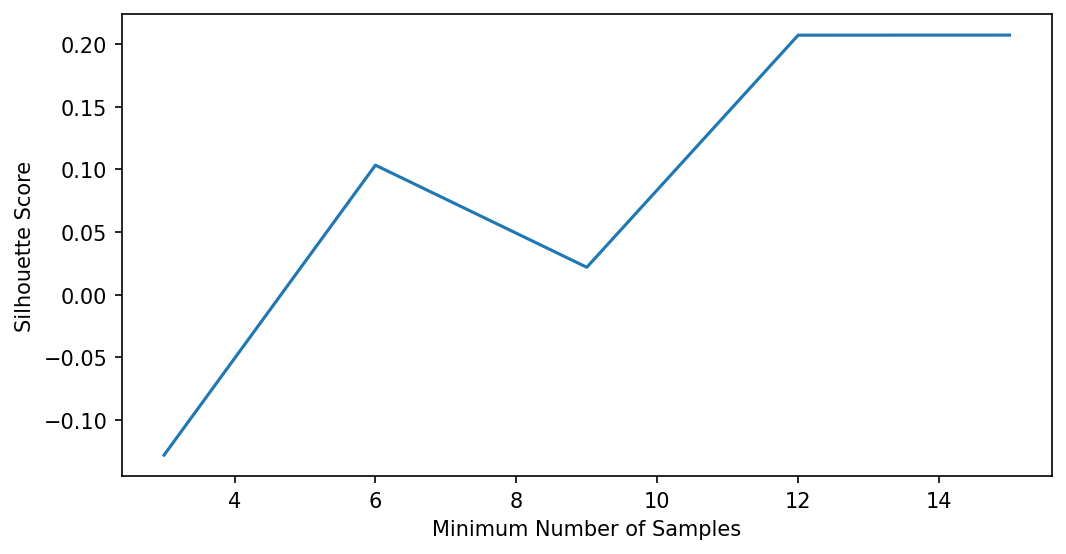

In [97]:
plt.figure(figsize=(8,4), dpi=150)
sns.lineplot(x=ms, y=silhouette_scores)
plt.xlabel('Minimum Number of Samples')
plt.ylabel('Silhouette Score')
plt.show()

<Axes: xlabel='Cluster'>

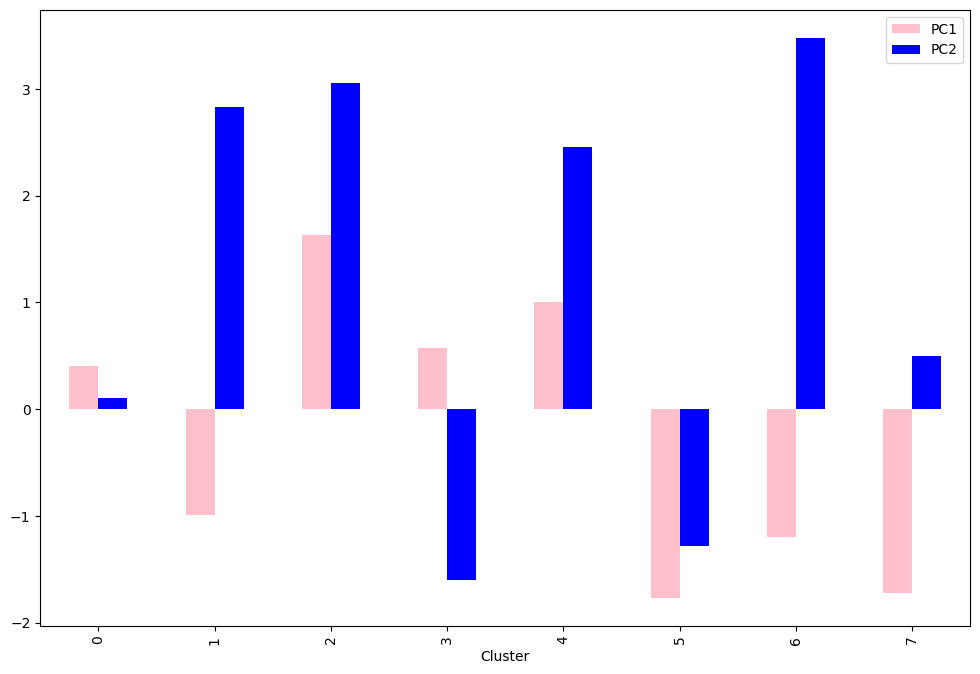

In [98]:
pca_components.groupby('Cluster')[['PC1','PC2']].mean().plot(kind='bar',color=['pink','blue'])

#### <span style="color: orange;">On Original Feature Space:</span>

In [99]:
temp = scaled_df.sample(n=10000)

In [100]:
base_spectral = SpectralClustering(random_state=101)
base_spectral.fit(temp)

SpectralClustering(random_state=101)

In [101]:
print("Estimated number of clusters:",set(base_spectral.labels_))

Estimated number of clusters: {0, 1, 2, 3}


In [102]:
print("Estimated number of noise points:",list(base_spectral.labels_).count(-1))

Estimated number of noise points: 0


In [103]:
print("Silhouette Score:",str(np.round(silhouette_score(temp,base_spectral.labels_)*100,2)) + '%')

Silhouette Score: 79.97%


<Axes: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

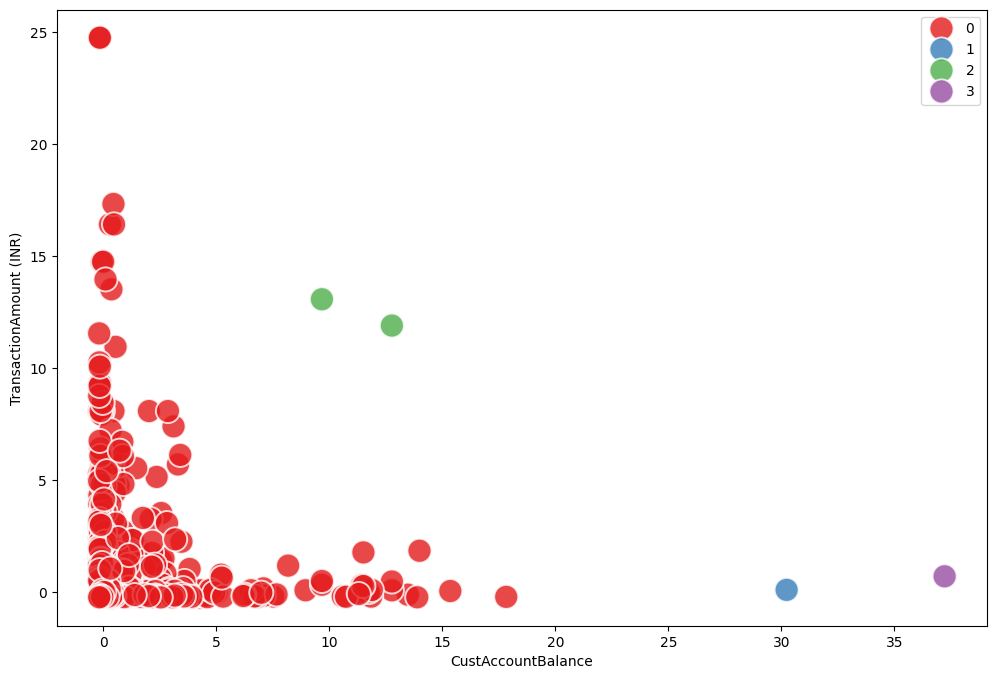

In [104]:
sns.scatterplot(data=temp,x='CustAccountBalance',y='TransactionAmount (INR)',hue=base_spectral.labels_,s=300,alpha=0.8,palette='Set1')

<span style="color: pink;">The Spectral clustering algorithm has segregated the customers into two distinct groups. The first group comprises the dynamic customers who have lower account balance and mostly expend less cash on transactions barring a few who perform large-value transactions whereas the second group includes the more conservative and money saving-minded people who, inspite of having really high account balances, spend the least amount of money in transactions, thereby judiciously maintaining their savings accounts.</span>